In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
%matplotlib inline

In [2]:
adni = pd.read_csv('../database_split/database_info/ADNI_data_information.csv')
display(adni.head())
adni = adni[['Subject ID', 'Research Group', 'Image Filename', 'MMSE Total Score']]
adni['Image Filename'] = adni['Image Filename'].apply(lambda x: x.split(".nii")[0])

/home/kpoloni/.local/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,Subject ID,Phase,Sex,Weight,Research Group,APOE A1,APOE A2,Visit,Archive Date,Study Date,Age,MMSE Total Score,GDSCALE Total Score,Global CDR,FAQ Total Score,NPI-Q Total Score,Modality,Description,Image ID,Image Filename
0,006_S_0731,ADNI 3,M,62.0,CN,3.0,3.0,ADNI3_Initial_Visit-Cont_Pt,9/19/2017,9/18/2017,82.7,NaN,NaN,NaN,NaN,NaN,MRI,Sagittal 3D Accelerated MPRAGE,905360,006_S_0731_ADNI3_Initial_Visit-Cont_Pt.nii.gz
1,035_S_4464,ADNI 3,M,83.9,CN,3.0,4.0,ADNI3_Initial_Visit-Cont_Pt,2/06/2018,2/01/2018,76.4,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,959742,035_S_4464_ADNI3_Initial_Visit-Cont_Pt.nii.gz
2,035_S_0555,ADNI 1,M,77.0,CN,3.0,4.0,ADNI1GO_Month_6,5/25/2007,5/24/2007,77.7,30.0,NaN,0.0,0.0,0.0,MRI,MPRAGE,55241,035_S_0555_ADNI1GO_Month_6.nii.gz
3,018_S_4399,ADNI 2,F,56.7,CN,3.0,4.0,ADNI2_Year_2_Visit,1/06/2014,1/06/2014,80.1,29.0,1.0,0.0,0.0,NaN,MRI,MPRAGE,403909,018_S_4399_ADNI2_Year_2_Visit.nii.gz
4,007_S_1222,ADNI 3,F,81.6,CN,2.0,3.0,ADNI3_Initial_Visit-Cont_Pt,1/18/2018,1/17/2018,84.4,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,955206,007_S_1222_ADNI3_Initial_Visit-Cont_Pt.nii.gz


In [3]:
cn = pd.read_csv('../predict_results/test_70-100_L.csv', sep=',')
cn['Research Group'] = 'CN'
ad = pd.read_csv('../predict_results/ad_70-100_L.csv', sep=',')
ad['Research Group'] = 'AD'
mci= pd.read_csv('../predict_results/mci_70-100_L.csv', sep=',')
mci['Research Group'] = 'MCI'
results = pd.concat([cn, ad, mci]).reset_index(drop=True)
# results=cn
results = results[['Name', 'True', 'Pred', 'Research Group']]
results.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

In [4]:
data = adni.merge(results, on=['Image Filename', 'Research Group']).reset_index(drop=True)
data.columns = ['Subject ID', 'group', 'Image Filename', 'MMSE', 'Chronological age', 'Estimated age']
data['Delta'] = data[['Chronological age', 'Estimated age']].apply(lambda x: x['Estimated age'] - x['Chronological age'], axis=1)
data.head()

,Subject ID,group,Image Filename,MMSE,Chronological age,Estimated age,Delta
0,035_S_0555,CN,035_S_0555_ADNI1GO_Month_6,30.0,77.7,75.035286,-2.664714
1,013_S_0502,CN,013_S_0502_ADNI_Screening,29.0,75.1,78.403470,3.303470
2,018_S_4349,CN,018_S_4349_ADNI2_Month_6-New_Pt,29.0,72.1,73.848366,1.748366
3,031_S_4032,CN,031_S_4032_ADNI2_Month_6-New_Pt,29.0,70.9,73.237885,2.337885
4,023_S_1306,CN,023_S_1306_ADNI_Screening,29.0,74.6,76.435220,1.835220


           n         r        CI95%       r2    adj_r2     p-val    BF10  \
pearson  102  0.337299  [0.15, 0.5]  0.11377  0.095867  0.000527  46.246   

            power  
pearson  0.939205  
linear relationship
ipykernel_launcher:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


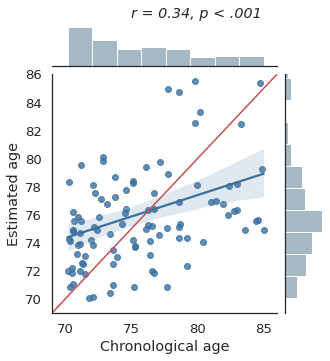

In [5]:

sns.set(style='white', font_scale=1.2)
dt = data[data.group=='CN']
pearson = pg.corr(dt['Estimated age'], dt['Chronological age'])
print(pearson)
print("linear relationship" if pearson['p-val'][0]<0.001 else "not linear relationship")
g = sns.JointGrid(data=dt, x='Chronological age', y='Estimated age',
                  xlim=(69, 86), ylim=(69, 86), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(75, 90, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()

linear relationship


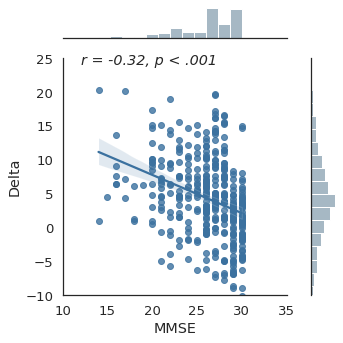

In [6]:

sns.set(style='white', font_scale=1.2)
pearson = pg.corr(data.MMSE, data.Delta)
print("linear relationship" if pearson['p-val'][0]<0.001 else "not linear relationship")
g = sns.JointGrid(data=data, x='MMSE', y='Delta', xlim=(10, 35), ylim=(-10, 25), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(12, 24, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
plt.tight_layout()
# plt.savefig("mmse_delta_L.pdf", bbox_inches='tight')

In [7]:
data

,Subject ID,group,Image Filename,MMSE,Chronological age,Estimated age,Delta
0,035_S_0555,CN,035_S_0555_ADNI1GO_Month_6,30.0,77.7,75.035286,-2.664714
1,013_S_0502,CN,013_S_0502_ADNI_Screening,29.0,75.1,78.403470,3.303470
2,018_S_4349,CN,018_S_4349_ADNI2_Month_6-New_Pt,29.0,72.1,73.848366,1.748366
3,031_S_4032,CN,031_S_4032_ADNI2_Month_6-New_Pt,29.0,70.9,73.237885,2.337885
4,023_S_1306,CN,023_S_1306_ADNI_Screening,29.0,74.6,76.435220,1.835220
...,...,...,...,...,...,...,...
371,011_S_0183,AD,011_S_0183_ADNI_Screening,21.0,72.5,82.518776,10.018776
372,032_S_0400,AD,032_S_0400_ADNI1GO_Month_12,20.0,70.4,85.548840,15.148840
373,022_S_0129,AD,022_S_0129_ADNI_Screening,22.0,80.3,86.811350,6.511350
374,073_S_4853,AD,073_S_4853_ADNI2_Year_1_Visit,25.0,72.0,77.481370,5.481370


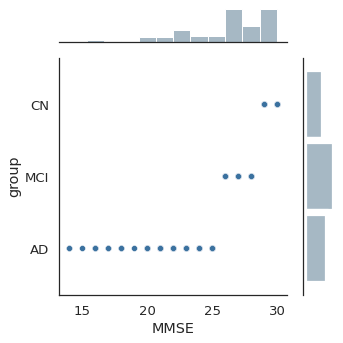

In [8]:
data['id'] = data.group.apply(lambda x: 1 if x=='AD' else 2 if x=='CN' else 0)
pearson = pg.corr(data.MMSE, data.id)
g = sns.JointGrid(data=data, x='MMSE', y='group', height=5)
g.plot_joint(sns.scatterplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
# g.ax_joint.text(4, -.5, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
plt.tight_layout()

<AxesSubplot:xlabel='Diagnosis groups', ylabel='MMSE'>

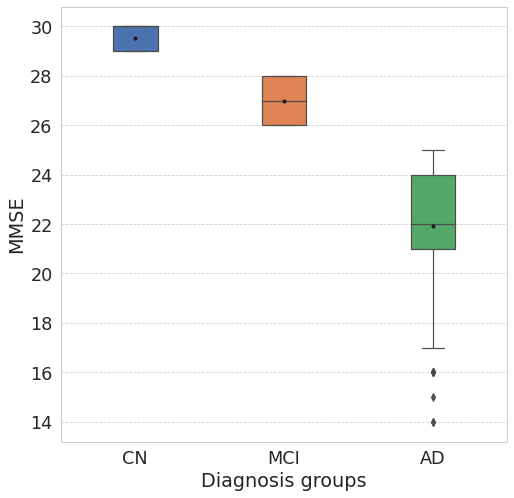

In [9]:
fig= plt.figure(figsize=(8,8))
sns.set(context='paper', 
#         palette='muted', 
        font='sans-serif',
       font_scale=2.0, color_codes=True)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['MMSE', 'group']]
dt.columns = ['MMSE', 'Diagnosis groups']
sns.boxplot(x="Diagnosis groups", y="MMSE", order=['CN', 'MCI', 'AD'],
            showmeans=True, 
            saturation=1.5,
            meanprops={"marker":"o",
                       "markersize":3,
                       "markerfacecolor":"k",
                       "markeredgecolor":"k"
                      },  
                       data=dt, width=0.3)
# plt.savefig("groups_boxplot_var.pdf", bbox_inches='tight')


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,43,0.939988,"[0.89, 0.97]",0.883578,0.877756,9.380094e-21,3.41e+17,1.0


True


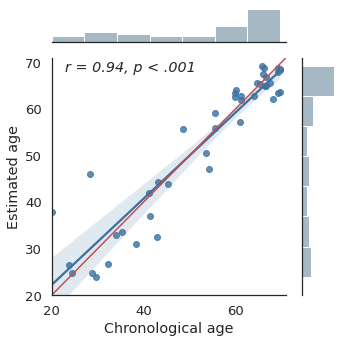

In [10]:
val = pd.read_csv('../predict_results/test_0-70_LR.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)
print(pearson['p-val'][0]<0.001)

sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_LR.pdf", bbox_inches='tight', dpi=300)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,43,0.891389,"[0.81, 0.94]",0.794574,0.784302,1.121256e-15,5.237e+12,1.0


linear relationship


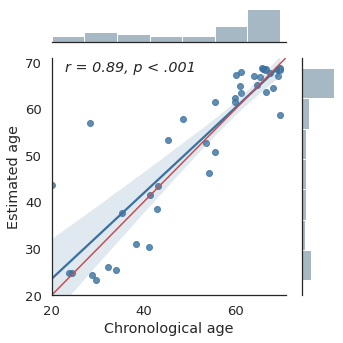

In [11]:
val = pd.read_csv('../predict_results/test_0-70_L.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'], tail='two-sided')
display(pearson)
print("linear relationship" if pearson['p-val'][0] < 0.01 else "")
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_L.pdf", bbox_inches='tight', dpi=300)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,43,0.925733,"[0.87, 0.96]",0.856982,0.849831,6.460374e-19,6.151e+15,1.0


linear relationship


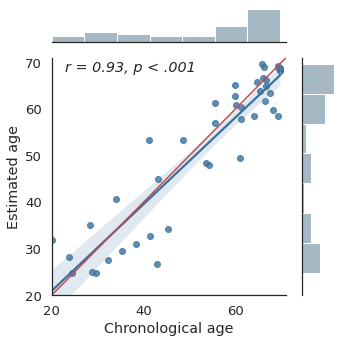

In [12]:
val = pd.read_csv('../predict_results/test_0-70_R.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)
print("linear relationship" if pearson['p-val'][0]<0.001 else "not linear relationship")
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_R.pdf", bbox_inches='tight', dpi=300)

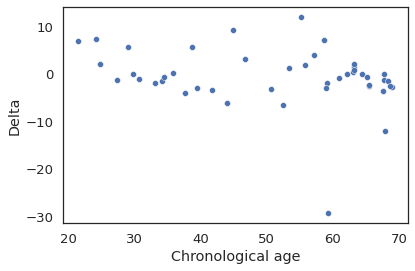

In [12]:
val = pd.read_csv('../predict_results/test_0-70_LR.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val['Delta'] = val[['True', 'Pred']].apply(lambda x: x[1]-x[0], axis=1)
# val.head()
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group', 'Delta']

sns.set(style='white', font_scale=1.2)
g = sns.scatterplot(data=val, x='Chronological age', y='Delta')
plt.tight_layout()
# plt.savefig("correlation_0-70_LR.pdf", bbox_inches='tight', dpi=300)